# 1. Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random

# Deep Learning utilities
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Torch data manipulation
import torchvision
from torchvision import transforms
import albumentations as A

# Confusion Matrix and Metrics
import torchmetrics as tm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Handling multiband images
import rasterio as rio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# 2. Variables - CONFIG

In [2]:
# Randomness control
RANDOM_SEED = 42

# Band config of hyperspectral image
BAND_CONFIG = [1, 2, 3, 4, 5, 6, 7, 8, 11, 12]

# Main working path
MAIN_PATH = '/kaggle/input/eurosat-dataset'

# 3. Data preparation

In [3]:
train_df = pd.read_csv(os.path.join(MAIN_PATH, 'EuroSATallBands', 'train.csv'))
test_df = pd.read_csv(os.path.join(MAIN_PATH, 'EuroSATallBands', 'test.csv'))
val_df = pd.read_csv(os.path.join(MAIN_PATH,'EuroSATallBands', 'validation.csv'))

data = [train_df, test_df, val_df]

def get_rgb_image_path(row):
    filename = os.path.join(MAIN_PATH,'EuroSAT', row)
    filename = filename.replace('.tif', '.jpg')
    return filename

for df in data:
    df['sat_image_path'] = df['Filename'].apply(lambda filename: os.path.join(MAIN_PATH,'EuroSATallBands', filename))
    df['rgb_image_path'] = df['Filename'].apply(get_rgb_image_path)
    
print(train_df.iloc[0]['sat_image_path'])
print(train_df.iloc[0]['rgb_image_path'])

/kaggle/input/eurosat-dataset/EuroSATallBands/PermanentCrop/PermanentCrop_2401.tif
/kaggle/input/eurosat-dataset/EuroSAT/PermanentCrop/PermanentCrop_2401.jpg


In [4]:
train_df.head()

,Filename,Label,ClassName,sat_image_path,rgb_image_path
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop,/kaggle/input/eurosat-dataset/EuroSATallBands/...,/kaggle/input/eurosat-dataset/EuroSAT/Permanen...
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop,/kaggle/input/eurosat-dataset/EuroSATallBands/...,/kaggle/input/eurosat-dataset/EuroSAT/Permanen...
2,HerbaceousVegetation/HerbaceousVegetation_1025...,2,HerbaceousVegetation,/kaggle/input/eurosat-dataset/EuroSATallBands/...,/kaggle/input/eurosat-dataset/EuroSAT/Herbaceo...
3,SeaLake/SeaLake_1439.tif,9,SeaLake,/kaggle/input/eurosat-dataset/EuroSATallBands/...,/kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...
4,River/River_1052.tif,8,River,/kaggle/input/eurosat-dataset/EuroSATallBands/...,/kaggle/input/eurosat-dataset/EuroSAT/River/Ri...


In [5]:
label_map = pd.read_json(os.path.join(MAIN_PATH, 'EuroSATallBands', 'label_map.json'), typ='dictionary')
label_names = label_map.keys().tolist()

print('Label map: \n')
print(label_map)
print('\n***********************\n')
print('Label names:')
print(label_names)

Label map: 

AnnualCrop              0
Forest                  1
HerbaceousVegetation    2
Highway                 3
Industrial              4
Pasture                 5
PermanentCrop           6
Residential             7
River                   8
SeaLake                 9
dtype: int64

***********************

Label names:
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# 4. Helper functions

In [6]:
def visualize_random_preds(n_samples,
                           df, 
                           model,
                           label_map=label_map,
                           band_config=BAND_CONFIG, 
                           normalize=None):
    """
    Visualize random predictions with corresponding labels
    Green text -> Predicted good label
    Red text -> Predicted bad label
    """
    
    # Prepare random sample list
    random_samples = random.sample(range(0, len(df), 1), n_samples)
    random_samples.sort()
    
    # Plot config
    columns = 5
    rows = len(random_samples) // columns
    plt.figure(figsize=(12,8))
    
    model.eval()
    model.to('cpu')
    # Prepare predictions
    for index, sample in enumerate(random_samples):
        # Get multiband image
        with rio.open(df['sat_image_path'].iloc[sample]) as src:
            image = src.read(band_config, out_dtype='float32')
        
        # Get label
        label = df['Label'].iloc[sample]
        label = torch.tensor(label, dtype=torch.long)
        
        # Get RGB image
        rgb_image = cv2.cvtColor(cv2.imread(df['rgb_image_path'].iloc[sample]),cv2.COLOR_BGR2RGB)
        
        # Normalize multiband image
        image = torch.from_numpy(image)
        if normalize:
            image = normalize(image)
        image = image.unsqueeze(dim=0)
        
        # Predict
        prediction = model(image)    
        predicted_label = torch.softmax(prediction, dim=1).argmax(dim=1)
            
        # Show img
        plt.subplot(columns, rows, index+1)
        plt.imshow(rgb_image)
        
        # Find the prediction label (in text form, e.g. "Sandal")
        pred_label_name = list(filter(lambda x: label_map[x] == predicted_label, label_map))[0]

        # Get the truth label (in text form, e.g. "T-shirt")
        truth_label_name = list(filter(lambda x: label_map[x] == label, label_map))[0] 

        # Create the title text of the plot
        title_text = f"Pred: {pred_label_name} | Truth: {truth_label_name}"
  
        # Check for equality and change title colour accordingly
        if pred_label_name == truth_label_name:
            plt.title(title_text, fontsize=10, c="g") # green text if correct
        else:
            plt.title(title_text, fontsize=10, c="r") # red text if wrong
        plt.axis(False)
        
    plt.show()
    
def calculate_tiff_statistics(df, band_config):
    """
    Tiff images statistics used for normalization - MEAN and STD
    """
    
    image_paths = df['sat_image_path']
    total_mean = 0
    total_std = 0
    
    for path in image_paths:
        img = rio.open(path).read(band_config)
        total_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
        total_std += img.reshape((img.shape[0], -1)).std(axis=1)
        
    average_mean = total_mean / len(image_paths)
    average_std = total_std / len(image_paths)
    
    return np.round(average_mean, 1), np.round(average_std, 1)
    
def get_training_transformation():
    train_transform = [A.HorizontalFlip(p=0.3),
                       A.VerticalFlip(p=0.3),
                      ]
    return A.Compose(train_transform)

def normalize_image():
    normalize = [
        transforms.Normalize(mean=mean, std=std)
    ]
    return transforms.Compose(normalize)

def plot_statistics(**statistic_lists):
    """
    Visualize provided statistics in a row with correlated name.
    Provide the argument in keyword args format: statistic_name = List[statistics]
    For example: Loss_statistic = [train_loss, test_loss]
    """    
    for index, (name, statistic_list) in enumerate(statistic_lists.items()):
        plt.figure(figsize=(12,8))
        label_name = name.split(' ')[0]
        plt.plot(statistic_list[0], label=f'Training {label_name}')
        plt.plot(statistic_list[1], label=f'Test {label_name}')
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.legend()

# 5. Dataset class

In [7]:
class EuroSATDataSet(Dataset):
    def __init__(self,
                 df,
                 band_config,
                 transform=None,
                 normalize=None
                ):
        self.df = df
        self.band_config = band_config
        self.transform = transform
        self.normalize = normalize
    
    def __len__(self):
        return len(self.df)
    
    def __str__(self):
        return f'<EuroSATDataSet class>'
    
    def __getitem__(self, index):
        with rio.open(self.df['sat_image_path'].iloc[index]) as src:
            image = src.read(self.band_config, out_dtype='float32')
                        
        label = self.df['Label'].iloc[index]
        label = torch.tensor(label, dtype=torch.long)
                             
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        image = torch.from_numpy(image)
        
        if self.normalize:
            image = self.normalize(image)
                             
        return image, label

In [8]:
mean, std = calculate_tiff_statistics(df=train_df,
                                     band_config=BAND_CONFIG)

print(f'Training dataset MEAN: {mean}')
print(f'Training dataset STD: {std}')

Training dataset MEAN: [1354.  1115.4 1033.3  934.8 1180.5 1964.9 2326.8 2254.5 1780.3 1098. ]
Training dataset STD: [ 64.2 150.7 183.8 272.3 223.1 348.6 445.5 519.4 370.3 296.9]


In [9]:
train_dataset = EuroSATDataSet(df=train_df,
                              band_config=BAND_CONFIG,
                              transform=get_training_transformation(),
                               normalize=normalize_image())

test_dataset = EuroSATDataSet(df=test_df,
                              band_config=BAND_CONFIG,
                              normalize=normalize_image())

In [10]:
train_dataloader = DataLoader(train_dataset,
                             batch_size=128,
                             shuffle=True,
                             num_workers=0,
                             drop_last=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=128,
                             shuffle=False,
                             num_workers=0,
                             drop_last=True)

In [11]:
# Check train batch shapes
batch = next(iter(train_dataloader))
images, labels = batch
print(f'Batch Image Shape: {images.shape}, Batch Label Shape: {labels.shape}')

image, label = images[0], labels[0]
print(f'Batch Image Type: {images.dtype}, Batch Label Type: {labels.dtype}')

# Check test batch shapes
batch = next(iter(test_dataloader))
images, labels = batch
print(f'Batch Image Shape: {images.shape}, Batch Label Shape: {labels.shape}')

image, label = images[0], labels[0]
print(f'Batch Image Type: {images.dtype}, Batch Label Type: {labels.dtype}')

Batch Image Shape: torch.Size([128, 10, 64, 64]), Batch Label Shape: torch.Size([128])
Batch Image Type: torch.float32, Batch Label Type: torch.int64
Batch Image Shape: torch.Size([128, 10, 64, 64]), Batch Label Shape: torch.Size([128])
Batch Image Type: torch.float32, Batch Label Type: torch.int64


# 7. Model - ResNet from scratch | Made only to gain knowledge of ResNet architecture

In [12]:
from typing import Type
from torch import Tensor

# Resnet18 based on https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

class BasicBlock(nn.Module):
    def __init__(self,
                in_channels: int,
                out_channels: int,
                stride:int = 1,
                expansion: int = 1,
                downsample: nn.Module = None
                ) -> None:
        
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=3,
                              stride=stride,
                              padding=1,
                              bias=False
                              )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(out_channels,
                              out_channels*self.expansion,
                              kernel_size=3,
                              padding=1,
                              bias=False
                              )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x:Tensor) -> Tensor:
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out) # Regularization method
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out
    
class ResNet18(nn.Module):
    def __init__(self,
                img_channels: int,
                block: Type[BasicBlock],
                num_classes: int,
                num_layers: int = 18
                ) -> None:
        super(ResNet18, self).__init__()
        if num_layers == 18:
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels,
                              out_channels=self.in_channels,
                              kernel_size=7,
                              stride=2,
                              padding=3,
                              bias=False
                              )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,
                                   stride=2,
                                   padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
        
    def _make_layer(self,
                   block: Type[BasicBlock],
                   out_channels: int,
                   blocks: int,
                   stride: int = 1
                   ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels,
                                                out_channels*self.expansion,
                                                kernel_size=1,
                                                stride=stride,
                                                bias=False
                                                ),
                                      nn.BatchNorm2d(out_channels*self.expansion)
                                      )
        layers = []
        layers.append(block(self.in_channels,
                            out_channels,
                            stride,
                            self.expansion,
                            downsample
                            ))
        
        self.in_channels = out_channels * self.expansion
            
        for i in range(1, blocks):
            layers.append(block(self.in_channels,
                                out_channels,
                                expansion=self.expansion
                                ))
        return nn.Sequential(*layers)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [13]:
model = ResNet18(img_channels=len(BAND_CONFIG),
                num_classes=len(label_map),
                block=BasicBlock)

# 8. Model - ResNet with pretrained weights

In [14]:
# Models and training loops made with https://wvview.org/geospatdl.html website help

def set_parameter_requires_grad(model, freeze=True):
    if freeze == True:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(resnet, in_channels, out_classes, freeze=True, pretrained=True):
    if resnet == "18":
        model = torchvision.models.resnet18(pretrained=pretrained)

    elif resnet == "34":
        model = torchvision.models.resnet34(pretrained=pretrained)

    elif resnet == "50":
        model = torchvision.models.resnet50(pretrained=pretrained)

    elif resnet == "101":
        model = torchvision.models.resnet101(pretrained=pretrained)

    elif resnet == "152":
        model = torchvision.models.resnet152(pretrained=pretrained)

    else:
        model = torchvision.models.resnet34(pretrained=pretrained)

    if pretrained == True:
        set_parameter_requires_grad(model, freeze)
        features = model.fc.in_features
        model.fc = nn.Linear(features, out_classes)

    if in_channels != 3:
        model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.bn1 = nn.BatchNorm2d(64)

    return model

In [15]:
model = initialize_model(resnet='34', in_channels=len(BAND_CONFIG), out_classes=len(label_map), freeze=False, pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 15.4MB/s]


# 9. Model training

In [16]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html


Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Metrics from torchmetrics
accuracy = tm.Accuracy(task='multiclass', num_classes=len(label_map)).to('cpu')
f1_score = tm.F1Score(task='multiclass', num_classes=len(label_map)).to('cpu')

In [18]:
epoch_number = []
train_f1_scores = []
train_accuracy_scores = []
train_loss_scores = []
test_f1_scores = []
test_accuracy_scores = []
test_loss_scores = []

def training_loop(n_epochs,
                  optimizer,
                  lr_scheduler,
                  model,
                  loss_fn,
                  train_dataloader,
                  validation_dataloader):
    
    for epoch in range(0, n_epochs):
        print(f'-----EPOCH: {epoch+1}/{n_epochs}-----')

        model.train()
        for (image, label) in train_dataloader:

            
            optimizer.zero_grad()
            
            prediction = model(image)
            loss = loss_fn(prediction, label)

            training_accuracy = accuracy(prediction, label)
            training_f1_score = f1_score(prediction, label)

            loss.backward()
            optimizer.step()

        training_accuracy = accuracy.compute()
        training_f1_score = f1_score.compute()

        print('************************************************')
        print(f"Train loss: {loss.item():.5f} | Train accuracy: {training_accuracy:.2f} | Train F1-Score: {training_f1_score:.2f}")

        epoch_number.append(epoch)
        train_f1_scores.append(training_f1_score.detach().cpu().numpy())
        train_accuracy_scores.append(training_accuracy.detach().cpu().numpy())
        train_loss_scores.append(loss.item())
        
        accuracy.reset()
        f1_score.reset()
        
        model.eval()
        with torch.no_grad():
            for (image, label) in validation_dataloader:
               
                prediction = model(image)
                test_loss = loss_fn(prediction, label)

                test_accuracy = accuracy(prediction, label)
                test_f1_score = f1_score(prediction, label)

        test_accuracy = accuracy.compute()
        test_f1_score = f1_score.compute()

        print(f"Test loss: {test_loss.item():.5f} | Test accuracy: {test_accuracy:.2f} | Test f1_score: {test_f1_score:.2f}")
        print('************************************************')
        
        test_accuracy_scores.append(test_accuracy.detach().cpu().numpy())  
        test_loss_scores.append(test_loss.item())
        
        accuracy.reset()
        
        test_f1_score_checker = test_f1_score.detach().cpu().numpy()
        
        #Append for the first epoch
        if epoch == 0:
            test_f1_scores.append(test_f1_score_checker)
            
        if test_f1_score_checker > max(test_f1_scores):
            torch.save(model.state_dict(), 'eurosat_classification_model.pt')
            print(f'[INFO] model saved for epoch: {epoch+1}')
        
        if epoch != 0:
            test_f1_scores.append(test_f1_score_checker)
            
        f1_score.reset()
        lr_scheduler.step()
        
    return

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

In [20]:
training_loop(n_epochs=30,
             optimizer=optimizer,
             lr_scheduler=scheduler,
             model = model,
             loss_fn=criterion,
             train_dataloader=train_dataloader,
             validation_dataloader=test_dataloader)

-----EPOCH: 1/30-----
************************************************
Train loss: 1.16770 | Train accuracy: 0.39 | Train F1-Score: 0.39
Test loss: 1.24934 | Test accuracy: 0.54 | Test f1_score: 0.54
************************************************
-----EPOCH: 2/30-----
************************************************
Train loss: 1.07540 | Train accuracy: 0.61 | Train F1-Score: 0.61
Test loss: 0.90074 | Test accuracy: 0.67 | Test f1_score: 0.67
************************************************
[INFO] model saved for epoch: 2
-----EPOCH: 3/30-----
************************************************
Train loss: 0.73318 | Train accuracy: 0.69 | Train F1-Score: 0.69
Test loss: 1.42534 | Test accuracy: 0.52 | Test f1_score: 0.52
************************************************
-----EPOCH: 4/30-----
************************************************
Train loss: 0.69686 | Train accuracy: 0.75 | Train F1-Score: 0.75
Test loss: 0.60136 | Test accuracy: 0.78 | Test f1_score: 0.78
*********************

# 10. Training statistics

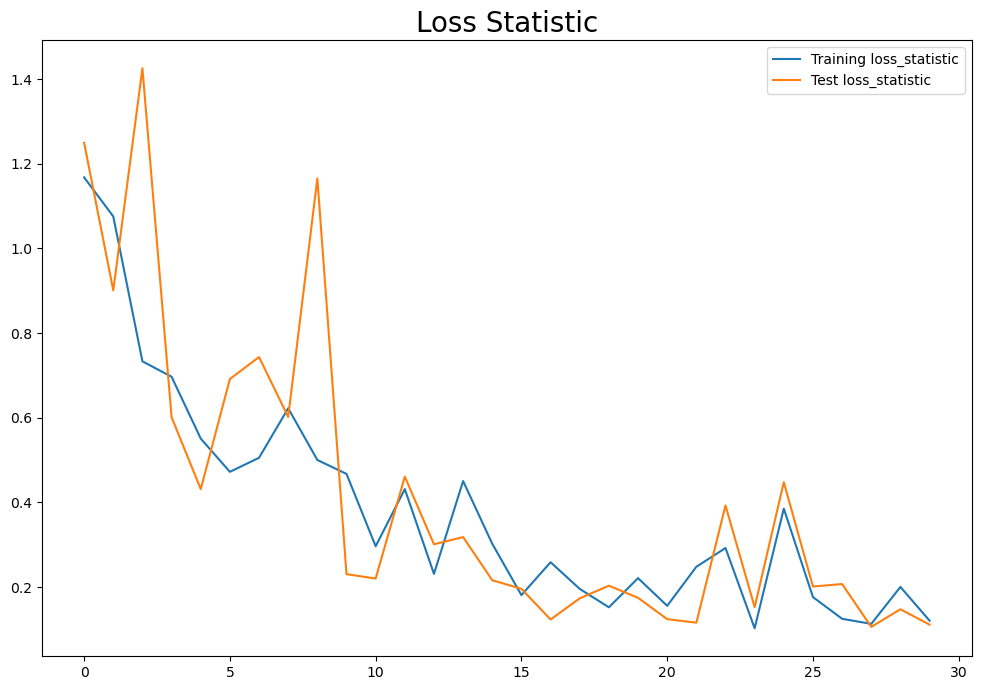

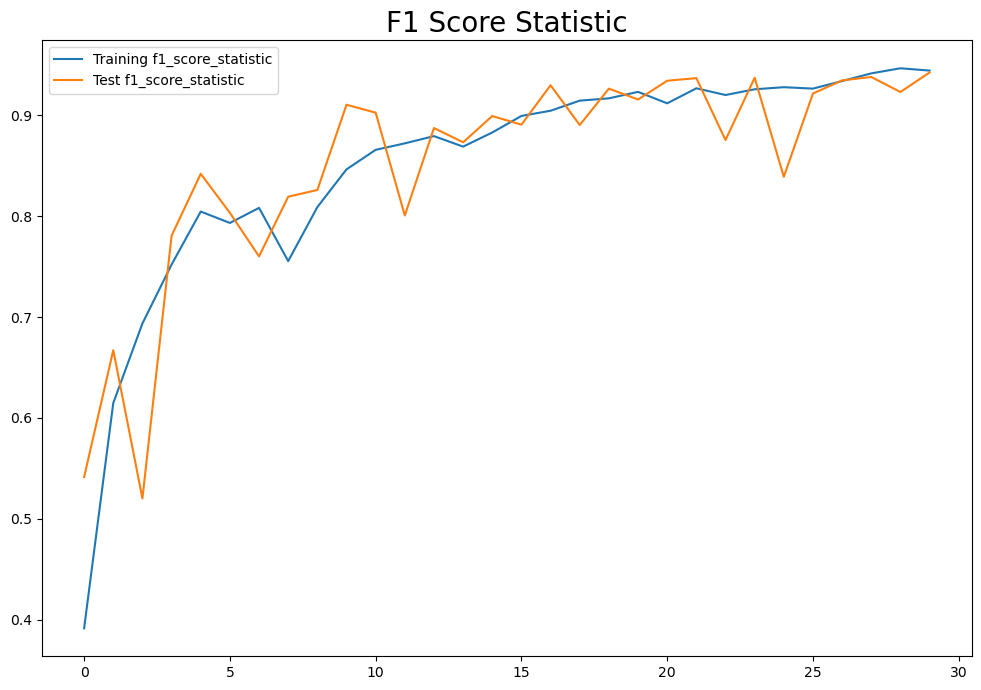

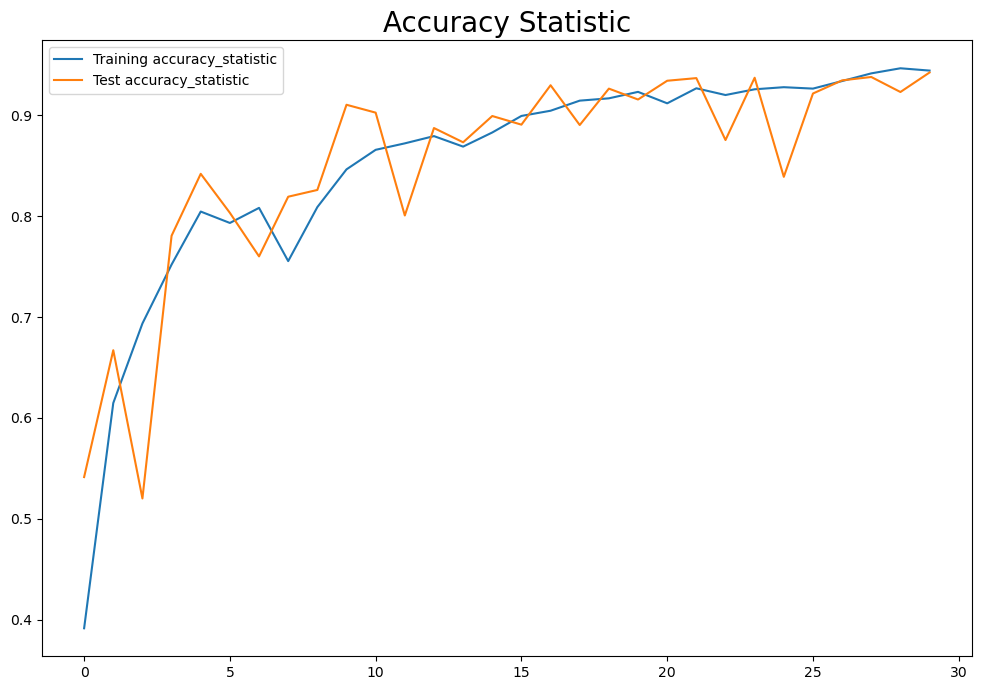

In [34]:
# Model statistics plotted with plot_statistics helper function
plot_statistics(loss_statistic = [train_loss_scores, test_loss_scores],
                f1_score_statistic = [train_f1_scores, test_f1_scores],
                accuracy_statistic = [train_accuracy_scores, test_accuracy_scores])

# 11. Model assessment with validation data

In [41]:
with open("../input/eurosat-dataset/EuroSATallBands/label_map.json","r") as f:
    class_names_encoded = json.load(f)
    pass

class_names = list(class_names_encoded.keys())
num_classes = len(class_names)
class_names_encoded

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [59]:
model = initialize_model(resnet='34', in_channels=len(BAND_CONFIG), out_classes=len(label_map), freeze=False, pretrained=True)
best_weights = torch.load('/kaggle/working/eurosat_classification_model.pt')
model.load_state_dict(best_weights)

<All keys matched successfully>

In [60]:
validation_dataset = EuroSATDataSet(df=val_df,
                                    band_config=BAND_CONFIG,
                                    normalize=normalize_image())

validation_dataloader = DataLoader(validation_dataset,
                                batch_size=128,
                                shuffle=False,
                                num_workers=0,
                                drop_last=True)

In [61]:
# Checking only F1 score here
f1_score = tm.F1Score(task='multiclass', num_classes=len(label_map))

In [62]:
validation_f1_scores = []
validation_loss_scores = []
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for (image, label) in validation_dataloader:
        prediction = model(image)
        validation_loss = criterion(prediction, label)
        
        predicted_label = torch.softmax(prediction, dim=1).argmax(dim=1)
        
        predictions.append(predicted_label.cpu())
        labels.append(label.cpu())

validation_f1_score = f1_score.compute()
validation_f1_scores.append(validation_f1_score.detach().cpu().numpy())
validation_loss_scores.append(validation_loss.item())
f1_score.reset()

predictions = torch.cat(predictions)
labels = torch.cat(labels)

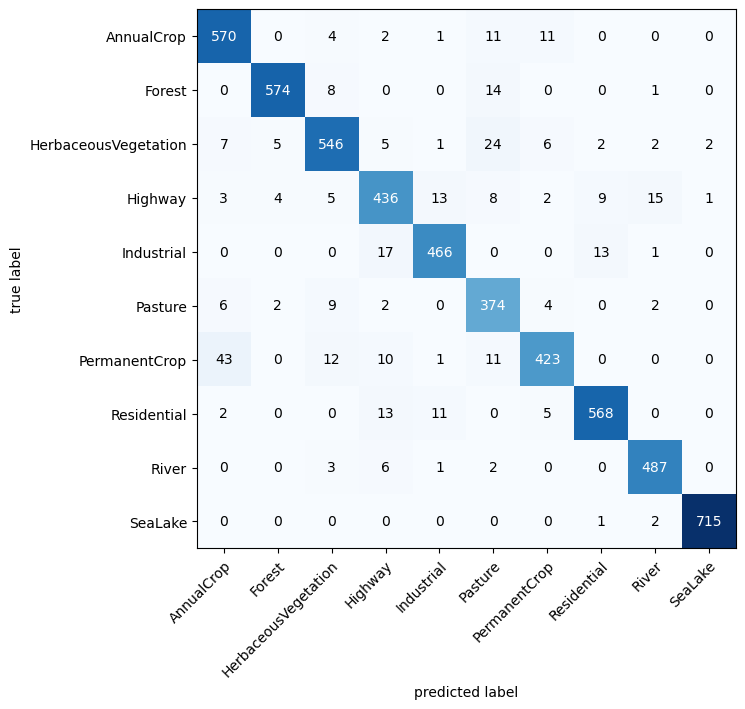

In [63]:
conf_matrix = ConfusionMatrix(num_classes=len(label_map), task='multiclass')
conf_matrix_tensor = conf_matrix(preds=predictions,
                                 target=labels)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(),
    class_names=label_map.keys().tolist(),
    figsize=(10, 7))

In [64]:
# Model assesments statistics
print(validation_loss_scores)
print(validation_f1_scores)

[0.17870749533176422]
[array(0., dtype=float32)]


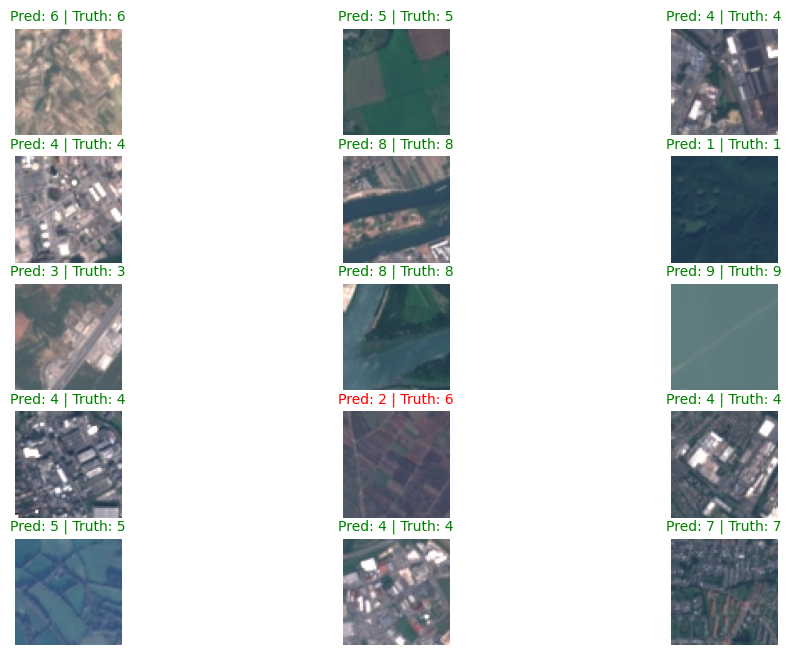

In [65]:
# Plot random predictions from validation set

visualize_random_preds(n_samples=15,
                      df=val_df,
                      model=model,
                      normalize=normalize_image())